In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
from salishsea_tools import Keegan_eval_tools as ket
import json
from collections import OrderedDict
from matplotlib.colors import LogNorm
import arrow
import glob
import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [3]:
yearList = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

data = 'month-avg.202111'
#year = '2014'
month = '01'
file = 'grid'

for year in yearList:
    files=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

## Bring in grid coordinates for Juan de Fuca slice/box

In [4]:
ii, ij = 300,365
ji, jj = 50, 100


In [5]:
JdF = [300,365, 50, 100]

In [6]:
## Gathering metadata but still not opening the files
JdFfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','votemper','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [7]:
np.shape(JdF)

(4,)

In [8]:
np.shape(JdFfiles.time)

(192,)

In [9]:
np.shape(tmask) 

(40, 898, 398)

In [10]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [11]:
JdFmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(192,40,65,50))

In [12]:
np.shape(JdFmask) 

(192, 40, 65, 50)

In [13]:
tt=np.array(JdFfiles.time)
JdF_depth=np.array(JdFfiles.depth)
JdF_vosaline=(JdFfiles.vosaline[:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
JdF_vosaline = (np.array(JdF_vosaline))

JdF_vosaline = np.ma.masked_where(JdFmask==0,JdF_vosaline) ## masking where there is land

JdF_vosaline=np.mean(JdF_vosaline, axis=(2,3))

In [14]:
np.shape(JdF_vosaline)

(192, 40)

## Bring in grid coordinates for Haro Strait slice/box

In [15]:
Haro = [280,320, 210, 250]

In [16]:
## Gathering metadata but still not opening the files
Harofiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','votemper','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [17]:
np.shape(Haro)

(4,)

In [18]:
np.shape(Harofiles.time)

(192,)

In [19]:
np.shape(tmask) 

(40, 898, 398)

In [20]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [21]:
Haromask=np.broadcast_to(tmask[:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]],(192,40,40,40))

In [22]:
np.shape(Haromask) 

(192, 40, 40, 40)

In [23]:
tt=np.array(Harofiles.time)
Haro_depth=np.array(Harofiles.depth)
Haro_vosaline=(Harofiles.vosaline[:,:, Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]])
Haro_vosaline = (np.array(Haro_vosaline))

Haro_vosaline = np.ma.masked_where(Haromask==0,Haro_vosaline) ## masking where there is land
Haro_vosaline=np.mean(Haro_vosaline, axis=(2,3))

In [24]:
np.shape(Haro_vosaline)

(192, 40)

## Bring in grid coordinates for Puget Sound slice/box

In [25]:
Puget = [75,125, 225, 280]

In [26]:
## Gathering metadata but still not opening the files
Pugetfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','votemper','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [27]:
np.shape(Puget)

(4,)

In [28]:
np.shape(Pugetfiles.time)

(192,)

In [29]:
np.shape(tmask) 

(40, 898, 398)

In [30]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [31]:
Pugetmask=np.broadcast_to(tmask[:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]],(192,40,50,55))

In [32]:
np.shape(Pugetmask) 

(192, 40, 50, 55)

In [33]:
tt=np.array(Pugetfiles.time)
Puget_depth=np.array(Pugetfiles.depth)
Puget_vosaline=(Pugetfiles.vosaline[:,:, Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]])
Puget_vosaline = (np.array(Puget_vosaline))

Puget_vosaline = np.ma.masked_where(Pugetmask==0,Puget_vosaline) ## masking where there is land

Puget_vosaline=np.mean(Puget_vosaline, axis=(2,3))

In [34]:
np.shape(Puget_vosaline)

(192, 40)

## Bring in grid coordinates for Northern SoG slice/box

In [35]:
NorthernSoG = [650,700, 140,180]

In [36]:
## Gathering metadata but still not opening the files
NSOGfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','votemper','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [37]:
np.shape(NorthernSoG)

(4,)

In [38]:
np.shape(NSOGfiles.time)

(192,)

In [39]:
np.shape(tmask) 

(40, 898, 398)

In [40]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [41]:
NSOGmask=np.broadcast_to(tmask[:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]],(192,40,50,40))

In [42]:
np.shape(NSOGmask) 

(192, 40, 50, 40)

In [43]:
tt=np.array(NSOGfiles.time)
NSOG_depth=np.array(NSOGfiles.depth)
NSOG_vosaline=(NSOGfiles.vosaline[:,:, NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]])
NSOG_vosaline = (np.array(NSOG_vosaline))

NSOG_vosaline = np.ma.masked_where(NSOGmask==0,NSOG_vosaline) ## masking where there is land

NSOG_vosaline=np.mean(NSOG_vosaline, axis=(2,3))

In [44]:
np.shape(NSOG_vosaline)

(192, 40)

## Bring in grid coordinates for Central SoG slice/box

In [45]:
CentralSoG = [450, 500,250,300]

In [46]:
## Gathering metadata but still not opening the files
CSOGfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','votemper','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [47]:
np.shape(CentralSoG)

(4,)

In [48]:
np.shape(CSOGfiles.time)

(192,)

In [49]:
np.shape(tmask) 

(40, 898, 398)

In [50]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [51]:
CSOGmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,40,50,50))

In [52]:
np.shape(CSOGmask) 

(192, 40, 50, 50)

In [53]:
tt=np.array(CSOGfiles.time)
CSOG_depth=np.array(CSOGfiles.depth)
CSOG_vosaline=(CSOGfiles.vosaline[:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
CSOG_vosaline = (np.array(CSOG_vosaline))

CSOG_vosaline = np.ma.masked_where(CSOGmask==0,CSOG_vosaline) ## masking where there is land

CSOG_vosaline=np.mean(CSOG_vosaline, axis=(2,3))

In [54]:
np.shape(CSOG_vosaline)

(192, 40)

In [55]:
region_names = ['JdF', 'Haro', 'Puget', 'NSOG', 'CSOG']

salinity_list = [JdF_vosaline, Haro_vosaline, Puget_vosaline,
                 NSOG_vosaline, CSOG_vosaline]

depth_list = [JdF_depth, Haro_depth, Puget_depth,
              NSOG_depth, CSOG_depth]

# Use dictionaries to associate results with region names
haloclines = {}
strengths = {}

for name, sal, depth in zip(region_names, salinity_list, depth_list):
    # Compute salinity gradient along depth
    sal_grad = np.zeros_like(sal)
    for i in range(sal.shape[1] - 1):
        sal_grad[:, i] = (sal[:, i] - sal[:, i + 1]) / (depth[i] - depth[i + 1])

    # Find index of maximum gradient
    loc_max = np.argmax(sal_grad, axis=1)
    loc_max_plus1 = np.minimum(loc_max + 1, sal.shape[1] - 1)

    # Broadcast depth to match sal shape
    depth_2d = np.tile(depth, (sal.shape[0], 1))

    # Extract depth and salinity at loc_max and loc_max + 1
    h1 = np.take_along_axis(depth_2d, loc_max[:, None], axis=1)
    h2 = np.take_along_axis(depth_2d, loc_max_plus1[:, None], axis=1)

    s1 = np.take_along_axis(sal, loc_max[:, None], axis=1)
    s2 = np.take_along_axis(sal, loc_max_plus1[:, None], axis=1)

    # Compute halocline depth and strength
    halocline = 0.5 * (h1 + h2)
    strength = (s2 - s1) / (h2 - h1)

    # Store in dictionaries
    haloclines[name] = halocline
    strengths[name] = strength

In [56]:
np.shape(haloclines['JdF'])

(192, 1)

## Dataset for climatology

In [57]:
clim=nc.Dataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_month_climatology_grid_T_20070101_20230831.nc')

In [58]:
clim.variables.keys()

dict_keys(['sossheig', 'votemper', 'vosaline', 'sigma_theta', 'e3t', 'gridY', 'gridX', 'depth', 'month'])

#### Now I need to mask for the climatology in each region

In [59]:
JdFclimmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(12,40,65,50)) ## mask for climatology files

Haroclimmask=np.broadcast_to(tmask[:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]],(12,40,40,40)) ## mask for climatology files

Pugetclimmask=np.broadcast_to(tmask[:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]],(12,40,50,55)) ## mask for climatology files

CSOGclimmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(12,40,50,50)) ## mask for climatology files

NSOGclimmask=np.broadcast_to(tmask[:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]],(12,40,50,40)) ## mask for climatology files

In [60]:
JdFclim=np.ma.masked_where(JdFclimmask==0,clim['vosaline'][:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])

Haroclim=np.ma.masked_where(Haroclimmask==0,clim['vosaline'][:,:, Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]])

Pugetclim=np.ma.masked_where(Pugetclimmask==0,clim['vosaline'][:,:, Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]])

CSOGclim=np.ma.masked_where(CSOGclimmask==0,clim['vosaline'][:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

NSOGclim=np.ma.masked_where(NSOGclimmask==0,clim['vosaline'][:,:, NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]])

In [61]:
JdFclim=np.mean(JdFclim, axis=(2, 3)) ## calculate the mean across the entire slice/box 4d to 2d array
Haroclim=np.mean(Haroclim, axis=(2, 3))
Pugetclim=np.mean(Pugetclim, axis=(2, 3))
NSOGclim=np.mean(NSOGclim, axis=(2, 3))
CSOGclim=np.mean(CSOGclim, axis=(2, 3))

In [62]:
clim['depth']

<class 'netCDF4._netCDF4.Variable'>
float32 depth(depth)
    long_name: Sea Floor Depth
    _FillValue: nan
    standard_name: sea_floor_depth
    units: metres
    positive: down
unlimited dimensions: 
current shape = (40,)
filling on

In [63]:
region_names = ['JdF', 'Haro', 'Puget', 'CSOG','NSOG']

salinity_list = [JdFclim,Haroclim,Pugetclim,CSOGclim,NSOGclim]

depth_list = [clim['depth'],clim['depth'],clim['depth'],clim['depth'],clim['depth']]

# Use dictionaries to associate results with region names
clim_haloclines = {}
clim_strengths = {}

for name, sal, depth in zip(region_names, salinity_list, depth_list):
    # 1. Compute salinity gradient along depth
    sal_grad = np.zeros_like(sal)
    for i in range(sal.shape[1] - 1):
        sal_grad[:, i] = (sal[:, i] - sal[:, i + 1]) / (depth[i] - depth[i + 1])

    # 2. Find index of maximum gradient
    loc_max = np.argmax(sal_grad, axis=1)
    loc_max_plus1 = np.minimum(loc_max + 1, sal.shape[1] - 1)

    # 3. Broadcast depth to match sal shape
    depth_2d = np.tile(depth, (sal.shape[0], 1))

    # 4. Extract depth and salinity at loc_max and loc_max + 1
    h1 = np.take_along_axis(depth_2d, loc_max[:, None], axis=1)
    h2 = np.take_along_axis(depth_2d, loc_max_plus1[:, None], axis=1)

    s1 = np.take_along_axis(sal, loc_max[:, None], axis=1)
    s2 = np.take_along_axis(sal, loc_max_plus1[:, None], axis=1)

    # 5. Compute halocline depth and strength
    clim_halocline = 0.5 * (h1 + h2)
    clim_strength = (s2 - s1) / (h2 - h1)

    # 6. Store in dictionaries
    clim_haloclines[name] = clim_halocline
    clim_strengths[name] = clim_strength

In [64]:
np.shape(clim_strengths['NSOG'])

(12, 1)

In [65]:
clim_strengths['CSOG'].max()

2.3248981032156144

In [66]:
# Repeat the 12-month climatology block for 16 years (192 months total)
JdFclim_strength = np.tile(clim_strengths['JdF'], (16, 1))
Haroclim_strength = np.tile(clim_strengths['Haro'], (16, 1))
Pugetclim_strength = np.tile(clim_strengths['Puget'], (16, 1))
CSOGclim_strength = np.tile(clim_strengths['CSOG'], (16, 1))
NSOGclim_strength = np.tile(clim_strengths['NSOG'], (16, 1))

In [67]:
np.shape(JdFclim_strength)

(192, 1)

(-1.0, 192.0)

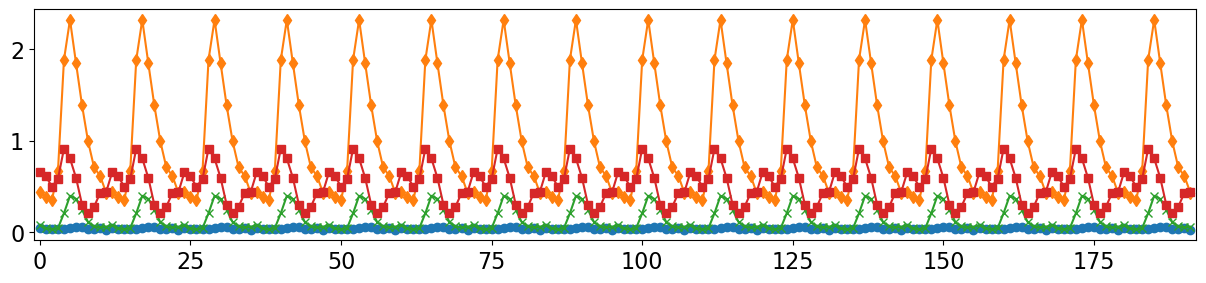

In [68]:
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(JdFclim_strength,marker='o')
ax.plot(CSOGclim_strength,marker='d')
ax.plot(NSOGclim_strength,marker='x')
ax.plot(Pugetclim_strength,marker='s')
ax.set_xlim(-1,192)

In [69]:
(strengths['JdF']-JdFclim_strength).max()

0.07314581714069687

In [70]:
JdFanomalies=np.array(strengths['JdF']-JdFclim_strength)
Haroanomalies=np.array(strengths['Haro']-Haroclim_strength)
Pugetanomalies=np.array(strengths['Puget']-Pugetclim_strength)
CSOGanomalies=np.array(strengths['CSOG']-CSOGclim_strength)
NSOGanomalies=np.array(strengths['NSOG']-NSOGclim_strength)

In [71]:
np.shape(JdFanomalies)

(192, 1)

In [72]:
JdFanomalies=JdFanomalies.flatten()
Haroanomalies=Haroanomalies.flatten()
Pugetanomalies=Pugetanomalies.flatten()
CSOGanomalies=CSOGanomalies.flatten()
NSOGanomalies=NSOGanomalies.flatten()

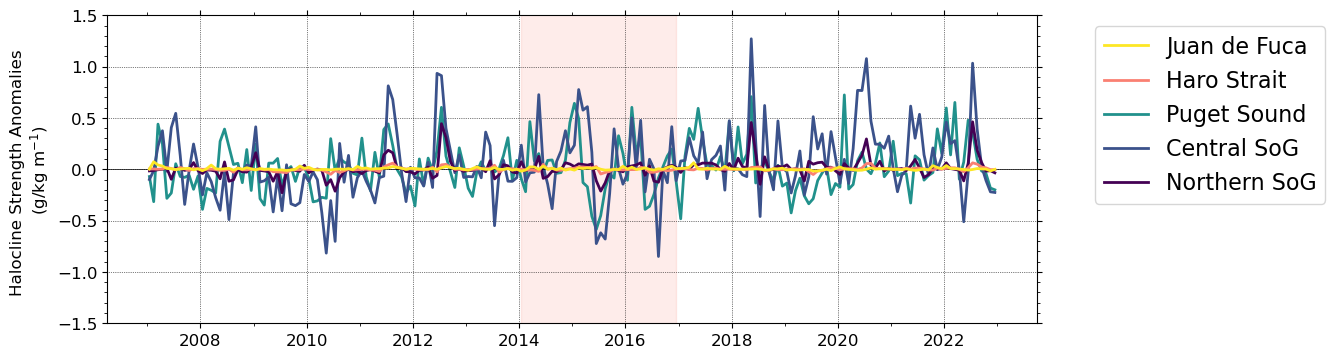

In [73]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
x=tt
y1 = np.ma.filled(JdFanomalies, np.nan)
y2 = np.ma.filled(Haroanomalies, np.nan)
y3 = np.ma.filled(Pugetanomalies, np.nan)
y4 = np.ma.filled(CSOGanomalies, np.nan)
y5 = np.ma.filled(NSOGanomalies, np.nan)


ax.plot(tt,y1,color='#fde725',linewidth=2,label='Juan de Fuca',zorder=10)
ax.plot(tt,y2,color='salmon',linewidth=2,label='Haro Strait',zorder=7)
ax.plot(tt,y3,color='#21918c',linewidth=2,label='Puget Sound')
ax.plot(tt,y4,color='#3b528b',linewidth=2,label='Central SoG')
ax.plot(tt,y5,color='#440154',linewidth=2,label='Northern SoG')
ax.set_ylim(-1.5,1.5)
ax.axhline(y=0,color='black',linewidth=0.5,linestyle='-')
ax.minorticks_on()
#plt.grid(which='major',axis ='y', linewidth='1', color='black')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', # Options for both major and minor ticks
                top='off', # turn off top ticks
                left='off', # turn off left ticks
                right='off',  # turn off right ticks
                bottom='off') # turn off bottom ticks
hloc = YearLocator(1)
ax.xaxis.set_minor_locator(hloc)
#ax.fill_between(x,y,where=y<0, color='blue')
#ax.fill_between(x,y,where=y>0, color='red')
ax.set_ylabel('Halocline Strength Anomalies \n(g/kg m$^{-1}$)',fontsize=12)

#ax.set_title('Halocline Anomalies - Juan de Fuca')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
a=tt[84]
b=tt[119]
plt.fill([a, a, b, b], [-3, 3, 3, -3], color = 'salmon', alpha = 0.15)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


#plt.savefig('Figure5_HaloclineAnom.png', bbox_inches='tight',dpi=1000,transparent=False)

plt.show()

In [74]:
JdFfiles.close()
Harofiles.close()
Pugetfiles.close()
CSOGfiles.close()
NSOGfiles.close()